In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
train = pd.read_csv("../input/train.csv",sep=",",nrows=3000000)

In [ ]:
test = pd.read_csv("../input/test.csv",sep=",")

In [ ]:
train.head()

In [ ]:
train.info()

In [ ]:
train.isna().sum()

In [ ]:
train.dropna(axis=0,inplace=True)

In [ ]:
train.isna().sum()

In [ ]:
sns.set_palette("viridis")
sns.set_style("whitegrid")

In [ ]:
train_fare_amt_sample_df = train.fare_amount.values[::1000]

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Fare Distribution")
plt.xlabel("Fares")
sns.distplot(train_fare_amt_sample_df,kde=False)

In [ ]:
train = train[train['fare_amount'].between(left = 2.5, right = 100)]

Before Beginning the analysis I would like to thank and credit the work of:
1. https://www.kaggle.com/willkoehrsen/a-walkthrough-and-a-challenge
2. https://www.kaggle.com/dster/nyc-taxi-fare-starter-kernel-simple-linear-model

These kernels were very inspiring and very explanatory.

In [ ]:
# Absolute difference in latitude and longitude
train['abs_lat_diff'] = (train['dropoff_latitude'] - train['pickup_latitude']).abs()
train['abs_lon_diff'] = (train['dropoff_longitude'] - train['pickup_longitude']).abs()

In [ ]:
def clean_engineer_data(df,train=True):
    # Absolute difference in latitude and longitude
    df['abs_lat_diff'] = (df['dropoff_latitude'] - df['pickup_latitude']).abs()
    df['abs_lon_diff'] = (df['dropoff_longitude'] - df['pickup_longitude']).abs()
    if(train):
        df = df[df['fare_amount'].between(left = 2.5, right = 100)]
         ########## Longitude and Latitude outlier removal ###############
        coords = ['pickup_longitude','pickup_latitude', 
          'dropoff_longitude', 'dropoff_latitude']
        for i in coords  : 
            df = df[(df[i]   > df[i].quantile(.025)) & 
                        (df[i] < df[i].quantile(.975))]
        # Passengers outlier removal when greater than 6 and less than 1
        df = df[df.passenger_count.between(left = 1, right = 6)]

    df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"])
    ########### Feature Engineering to split date into multiple columns
    df["Year"] = df.pickup_datetime.apply(lambda x: x.year)
    df["Month"] = df.pickup_datetime.apply(lambda x: x.month)
    df["date"] = df.pickup_datetime.apply(lambda x: x.day)
    df["Hour"] = df.pickup_datetime.apply(lambda x: x.hour)
    
    daysofweek = {
    0: "Monday",
    1: "Tuesday",
    2: "Wednesday",
    3: "Thursday",
    4: "Friday",
    5: "Saturday",
    6: "Sunday"
    }

    df["day_of_pickup"] = df["pickup_datetime"].apply(lambda x: daysofweek[x.dayofweek])

    return df

In [ ]:
#Passenger Filter
sns.countplot(x="passenger_count",data=train)

In [ ]:
# Passengers outlier removal when greater than 6 and less than 1
train = train[train.passenger_count.between(left = 1, right = 6)]

In [ ]:
#Passenger Filter
sns.countplot(x="passenger_count",data=train)

In [ ]:
########## Longitude and Latitude outlier removal ###############
coords = ['pickup_longitude','pickup_latitude', 
          'dropoff_longitude', 'dropoff_latitude']
for i in coords  : 
    train = train[(train[i]   > train[i].quantile(.025)) & 
                        (train[i] < train[i].quantile(.975))]

In [ ]:
plt.title("Regression Plot for pickup coordinates")
sns.regplot(x="pickup_longitude",y="pickup_latitude",data=train.sample(10000,random_state=101))

In [ ]:
plt.title("Regression Plot for pickup coordinates")
sns.regplot(x="dropoff_longitude",y="dropoff_latitude",data=train.sample(10000,random_state=101))

In [ ]:
len(train)

In [ ]:
train["pickup_datetime"] = pd.to_datetime(train["pickup_datetime"])

In [ ]:
########### Feature Engineering to split date into multiple columns
train["Year"] = train.pickup_datetime.apply(lambda x: x.year)
train["Month"] = train.pickup_datetime.apply(lambda x: x.month)
train["date"] = train.pickup_datetime.apply(lambda x: x.day)
train["Hour"] = train.pickup_datetime.apply(lambda x: x.hour)

In [ ]:
train.head(10)

In [ ]:
#Group By Year
train.groupby("Year")["fare_amount"].mean().plot()

In [ ]:
#Group By Month
train.groupby("Month")["fare_amount"].mean().plot()

In [ ]:
#Group By Hour
train.groupby("Hour").mean()["fare_amount"].plot()

In [ ]:
daysofweek = {
    0: "Monday",
    1: "Tuesday",
    2: "Wednesday",
    3: "Thursday",
    4: "Friday",
    5: "Saturday",
    6: "Sunday"
}

train["day_of_pickup"] = train["pickup_datetime"].apply(lambda x: daysofweek[x.dayofweek])

In [ ]:
pickuptimeVals = train.groupby(by=["day_of_pickup","Hour"]).count()["fare_amount"].unstack()
plt.figure(figsize=(15,10))
sns.heatmap(pickuptimeVals,cmap='viridis')

In [ ]:
pickuptimeVals = train.groupby(by=["day_of_pickup","Month"]).mean()["fare_amount"].unstack()
plt.figure(figsize=(15,10))
sns.heatmap(pickuptimeVals,cmap='viridis')

## Compute Distance for the trip based on longitude and latitude

### Distance for the ride can be computed using longitude and latitude using:

1. Eucliedean Distance:
Assuming that the travel is done for short distance, the travel is assumed to be flat.
 Euclidean metric is the "ordinary" straight-line distance between two points in Euclidean space. It is generalized to be a  L^2 distance.
 
 Formula:
In the Euclidean plane, if p = (p1, p2) and q = (q1, q2) then the distance is given by:
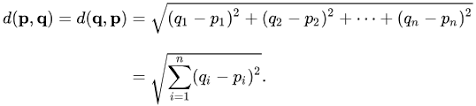

2. Haversine Formula
The Haversine formula calculates the shortest distance between two points on a sphere using their latitudes and longitudes measured along the surface. It is important for use in navigation. The haversine can be expressed in trignometric function.

More info here: 
https://www.geeksforgeeks.org/haversine-formula-to-find-distance-between-two-points-on-a-sphere/


In [ ]:
import math
def euclideanDistance(lngPickUp,latPickUp,lngDrop,latDrop):
    return np.sqrt((abs(lngPickUp - lngDrop)**2) + (abs(latPickUp - latDrop)**2) )

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2( np.sqrt(a), np.sqrt(1-a) ) 
    r = 6373.0 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

In [ ]:
train["euclideanDistance"] = euclideanDistance(train["pickup_longitude"],train["pickup_latitude"],
                                               train["dropoff_longitude"],train["dropoff_latitude"])

In [ ]:
train["haversineDistance"] = haversine(train["pickup_longitude"],train["pickup_latitude"],train["dropoff_longitude"],
                                       train["dropoff_latitude"])

In [ ]:
train.head(20)

In [ ]:
###Plots
f, (ax1, ax2) = plt.subplots(ncols=2,figsize=(10,6))
sns.distplot(train["euclideanDistance"],ax=ax1,color="gold")
sns.distplot(train["haversineDistance"],ax=ax2)

In [ ]:
plt.figure(figsize=(10,8))
sns.jointplot(x= "euclideanDistance", y="fare_amount", data=train.sample(1000,random_state=101),kind="hex",color="red")
plt.title("Fare Amount vs Euclidean Distance")

In [ ]:
plt.figure(figsize=(10,8))
sns.jointplot(x= "haversineDistance", y="fare_amount", data=train.sample(1000,random_state=101),kind="kde",color="red")
plt.title("Fare Amount vs Haversine Distance")

In [ ]:
# Compute the correlation matrix
corr = train.corr()

def drawCorrelationPlot(corr):
    ''' Quickly plots correlation for the dataset'''
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(15, 9))
    
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, fmt="d", center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
drawCorrelationPlot(corr)

In [ ]:
#Machine Learning
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import *

In [ ]:
test = clean_engineer_data(test,train=False)

In [ ]:
test["euclideanDistance"] = euclideanDistance(test["pickup_longitude"],test["pickup_latitude"],
                                               test["dropoff_longitude"],test["dropoff_latitude"])
test["haversineDistance"] = haversine(test["pickup_longitude"],test["pickup_latitude"],test["dropoff_longitude"],
                                       test["dropoff_latitude"])

In [ ]:
test.head()

In [ ]:
len(test)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train, np.array(train['fare_amount']), test_size=0.33, random_state=42)

In [ ]:
lm = LinearRegression()

In [ ]:
lm.fit(X_train[['passenger_count', 'abs_lat_diff', 'abs_lon_diff']],y_train)

In [ ]:
print('Intercept', round(lm.intercept_, 4))
print('abs_lat_diff coef: ', round(lm.coef_[1], 4), 
      '\tabs_lon_diff coef:', round(lm.coef_[2], 4),
      '\tpassenger_count coef:', round(lm.coef_[0], 4))

In [ ]:
### Random Forest for Regression ################
from sklearn.ensemble import RandomForestRegressor

In [ ]:
param_grid ={
 'bootstrap': [True],
 'max_depth': [80],
 'max_features': ["auto"],
 'min_samples_leaf': [5],
 'min_samples_split': [12],
 'n_estimators': [100]}

In [ ]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    rmse = np.sqrt(mean_squared_error(test_labels, predictions))
    accuracy = 100 - mape
    print('Model Performance')
    print('RMSE = {:0.2f}.'.format(rmse))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    return accuracy,rmse

In [ ]:
#gridcv = GridSearchCV(RandomForestRegressor(),param_grid,verbose=2,cv=3,n_jobs = -1)
#gridcv.fit(X_train[['passenger_count', 'abs_lat_diff', 'abs_lon_diff', 'haversineDistance']],y_train)

In [ ]:
acc,rmse = evaluate(lm,X_test[['passenger_count', 'abs_lat_diff', 'abs_lon_diff']],y_test)

In [ ]:
y_pred_final = lm.predict(test[['passenger_count', 'abs_lat_diff', 'abs_lon_diff']])

submission = pd.DataFrame(
    {'key': test.key, 'fare_amount': y_pred_final},
    columns = ['key', 'fare_amount'])
submission.to_csv('submission.csv', index = False)

Next Update is use:
1. Neural Network
2. Tree Models (Random Forest Regressor, Gradient Boosting, XGBoost)
3. SVM